In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [4]:
sns.set_context('poster')

In [5]:
ppallete = "BuGn"
porder = ['MIT9313', 'Natl2A', 'C9B', 'MIT9312', 'MED4']
pedge = 'green'
apallete = "Oranges"
aorder = ['1A3', 'DE', 'DE1', 'ATCC', 'BS11']
aedge='orange'              

In [6]:
df = pd.read_pickle('CCPA.pkl.gz')

In [7]:
dfc = df.loc[(df.experiment.isin(['e1','e3', 'e4','e5', 'e6'])) & (df.culture == 'Co_Culture')]

In [8]:
df3 = df.loc[(df.experiment.isin(['e3'])) & (df.culture == 'Co_Culture') & (df.ALT == 'DE1')]

In [86]:
d = cp.generate_decline(dfc, scale=False)
d = d.loc[d.day < 85]

In [12]:
dfc.groupby('experiment_sample')['day'].max().value_counts()

140.708333    73
140.900000    72
140.930000    69
122.760000    65
120.900000    64
Name: day, dtype: int64

In [13]:
train_df_orig, test_df_orig = cp.split_train_test(dfc,test_size=0.4)

In [30]:
max_day = 120
train_df = cp.augment_training(train_df_orig)
#train_df = train_df.loc[train_df.day <= max_day]
test_df = cp.resample_df(test_df_orig, period='1d', dropna=False)
#test_df = test_df.loc[test_df.day <= max_day]

In [31]:
train_df.head()

,experiment_sample,experiment,sample,PRO,ALT,culture,day,FL,augment_name,experiment_sample_orig
0,"e1, 10A, original_mean",e1,10A,C9B,DE,Co_Culture,0,0.078,original_mean,"e1, 10A"
1,"e1, 10A, original_mean",e1,10A,C9B,DE,Co_Culture,1,0.147,original_mean,"e1, 10A"
2,"e1, 10A, original_mean",e1,10A,C9B,DE,Co_Culture,2,0.175,original_mean,"e1, 10A"
3,"e1, 10A, original_mean",e1,10A,C9B,DE,Co_Culture,3,NaN,original_mean,"e1, 10A"
4,"e1, 10A, original_mean",e1,10A,C9B,DE,Co_Culture,4,NaN,original_mean,"e1, 10A"


In [32]:
X_train = cp.experiments2X(train_df, cumsummode=False, value_col='FL')
metadf_train = cp.get_meta(train_df)
metadf_train.index = metadf_train.experiment_sample

In [36]:
X_test = cp.experiments2X(test_df, cumsummode=False, value_col='FL', dropna=False)
metadf_test = cp.get_meta(test_df)
metadf_test.index = metadf_test.experiment_sample


In [38]:
X_train.columns, X_test.columns

(Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
             ...
             133, 134, 135, 136, 137, 138, 139, 140, 141, 142],
            dtype='int64', name='day', length=143),
 Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
             ...
             131, 132, 133, 134, 135, 136, 137, 138, 139, 140],
            dtype='int64', name='day', length=141))

In [40]:
X_train = X_train.loc[:, range(max_day+1)]
X_test = X_test.loc[:, range(max_day+1)]

In [41]:
X_train.shape, X_test.shape

((12300, 121), (138, 121))

In [42]:
y_train = metadf_train.PRO 
y_test = metadf_test.PRO 


In [43]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12300, 121), (12300,), (138, 121), (138,))

In [44]:
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
# # fit and evaluate a model
# def evaluate_model(trainX, trainy, testX, testy):
#     verbose, epochs, batch_size = 0, 10, 32
#     n_timesteps, n_features, n_outputs = trainX.shape[1], 1, trainy.nunique()
#     model = Sequential()
#     model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
#     model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Flatten())
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(n_outputs, activation='softmax'))
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     # fit network
#     model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
#     # evaluate model
#     _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
#     return accuracy

# # summarize scores
# def summarize_results(scores):
#     print(scores)
#     m, s = mean(scores), std(scores)
#     print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# # run an experiment
# def run_experiment(repeats=10):
#     # load data
#     trainX, trainy, testX, testy = load_dataset()
#     # repeat experiment
#     scores = list()
#     for r in range(repeats):
#         score = evaluate_model(trainX, trainy, testX, testy)
#         score = score * 100.0
#         print('>#%d: %.3f' % (r+1, score))
#         scores.append(score)
#     # summarize results
#     summarize_results(scores)

# run the experiment
#run_experiment()

In [45]:
    scalar = StandardScaler()
    scaledX_train = scalar.fit_transform(X_train)
    scaledX_test = scalar.transform(X_test)


In [47]:
X_train_keras = np.expand_dims(np.array(scaledX_train), axis=3).astype(np.float32)
X_test_keras = np.expand_dims(np.array(scaledX_test), axis=3).astype(np.float32)

C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """Entry point for launching an IPython kernel.
C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


In [48]:
from sklearn.preprocessing import LabelBinarizer
# convert the labels from integers to vectors (for 2-class, binary
# classification you should use Keras' to_categorical function
# instead as the scikit-learn's LabelBinarizer will not return a
# vector)
lb = LabelBinarizer()
y_train_keras = lb.fit_transform(y_train)
y_test_keras = lb.transform(y_test)

# y_test_keras_df = pd.get_dummies(y_test)
# y_test_keras = y_test_keras_df.values.astype(np.float32)

In [67]:
    verbose, epochs, batch_size = 1, 10, 32
    n_timesteps, n_features, n_outputs = X_train_keras.shape[1], X_train_keras.shape[2], y_train_keras.shape[1]
    n_timesteps, n_features, n_outputs 
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
    # fit network
    H = model.fit(X_train_keras, y_train_keras, epochs=epochs, batch_size=batch_size, verbose=verbose,
                 validation_data=(X_test_keras, y_test_keras))
#     # evaluate model
#     _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
#     return accuracy

Train on 12300 samples, validate on 138 samples
Epoch 1/10
12300/12300 [==============================] - 24s 2ms/step - loss: 0.1513 - acc: 0.9516 - val_loss: 1.3388 - val_acc: 0.8478
Epoch 2/10
12300/12300 [==============================] - 9s 697us/step - loss: 0.0256 - acc: 0.9920 - val_loss: 1.3612 - val_acc: 0.8406
Epoch 3/10
12300/12300 [==============================] - 9s 734us/step - loss: 0.0224 - acc: 0.9930 - val_loss: 1.6521 - val_acc: 0.8551
Epoch 4/10
12300/12300 [==============================] - 9s 722us/step - loss: 0.0123 - acc: 0.9962 - val_loss: 1.4686 - val_acc: 0.8478
Epoch 5/10
12300/12300 [==============================] - 10s 773us/step - loss: 0.0161 - acc: 0.9946 - val_loss: 1.8922 - val_acc: 0.8261
Epoch 6/10
12300/12300 [==============================] - 10s 776us/step - loss: 0.0075 - acc: 0.9972 - val_loss: 1.7838 - val_acc: 0.8333
Epoch 7/10
12300/12300 [==============================] - 10s 830us/step - loss: 0.0083 - acc: 0.9973 - val_loss: 1.6295 - 

In [60]:
model.evaluate(X_train_keras, y_train_keras, batch_size=batch_size, verbose=1)

12300/12300 [==============================] - 2s 187us/step


[0.0001337822761763711, 1.0]

In [61]:
model.evaluate(X_test_keras, y_test_keras, batch_size=batch_size, verbose=1)

138/138 [==============================] - 0s 226us/step


[1.7222804159357927, 0.8333333324694979]

In [62]:
from sklearn.metrics import classification_report
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(X_test_keras, batch_size=32)
print(classification_report(y_test_keras.argmax(axis=1),
    predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

         C9B       0.95      0.77      0.85        26
        MED4       0.90      0.70      0.79        27
     MIT9312       0.77      0.93      0.84        29
     MIT9313       0.84      1.00      0.92        27
      Natl2A       0.76      0.76      0.76        29

    accuracy                           0.83       138
   macro avg       0.85      0.83      0.83       138
weighted avg       0.84      0.83      0.83       138



In [63]:
predictions.argmax(axis=1)

array([0, 0, 1, 3, 2, 2, 4, 0, 1, 3, 2, 4, 1, 0, 1, 3, 2, 4, 4, 3, 2, 2,
       4, 0, 0, 2, 4, 4, 0, 4, 1, 3, 3, 2, 2, 4, 0, 0, 1, 3, 2, 2, 4, 1,
       0, 3, 3, 2, 4, 4, 2, 4, 0, 1, 3, 2, 2, 4, 0, 0, 2, 0, 1, 3, 3, 4,
       1, 1, 0, 1, 1, 3, 2, 2, 4, 3, 3, 4, 0, 1, 1, 3, 2, 2, 0, 3, 3, 2,
       2, 4, 0, 4, 3, 3, 2, 2, 2, 4, 4, 3, 3, 4, 3, 2, 4, 3, 2, 4, 2, 0,
       2, 2, 3, 3, 4, 0, 1, 3, 3, 2, 4, 3, 1, 2, 4, 3, 1, 2, 1, 1, 3, 2,
       2, 0, 1, 3, 4, 4], dtype=int64)

In [64]:
h_df = pd.DataFrame(data=H.history)

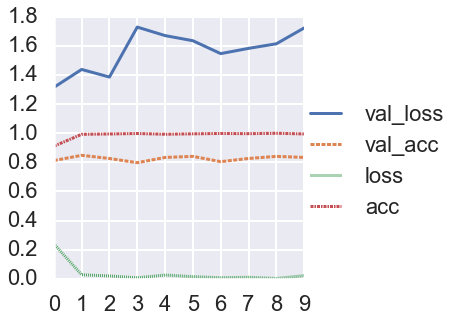

In [65]:
sns.relplot(data=h_df, kind='line')

In [66]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 115, 64)           512       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 109, 64)           28736     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 54, 64)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 54, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3456)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                221248    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total para